In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [51]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [52]:
df = pd.read_parquet('cleaned/netflix_parquet')

In [53]:
df
df.iloc[0]
df['review_data'].iloc[0]

,movieId,year,title,review_data
0,1,2003,Dinosaur Planet,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
1,2,2004,Isle of Man TT 2004 Review,"[{'date': 2005-09-05, 'rating': 4.0, 'userId':..."
2,3,1997,Character,"[{'date': 2003-03-29, 'rating': 4.0, 'userId':..."
3,4,1994,Paula Abdul's Get Up & Dance,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
4,5,2004,The Rise and Fall of ECW,"[{'date': 2005-02-08, 'rating': 5.0, 'userId':..."
...,...,...,...,...
768,13508,1999,The League of Gentlemen: Series 1,"[{'date': 2003-12-18, 'rating': 2.0, 'userId':..."
769,13509,1998,Little City,"[{'date': 2003-05-29, 'rating': 3.0, 'userId':..."
770,13510,1959,Last Train from Gun Hill,"[{'date': 2005-09-02, 'rating': 3.0, 'userId':..."
771,13511,1993,Much Ado About Nothing,"[{'date': 2000-10-01, 'rating': 4.0, 'userId':..."


movieId                                                        1
year                                                        2003
title                                            Dinosaur Planet
review_data    [{'date': 2005-09-06, 'rating': 3.0, 'userId':...
Name: 0, dtype: object

array([{'date': datetime.date(2005, 9, 6), 'rating': 3.0, 'userId': '1488844'},
       {'date': datetime.date(2005, 5, 13), 'rating': 5.0, 'userId': '822109'},
       {'date': datetime.date(2005, 10, 19), 'rating': 4.0, 'userId': '885013'},
       {'date': datetime.date(2005, 12, 26), 'rating': 4.0, 'userId': '30878'},
       {'date': datetime.date(2004, 5, 3), 'rating': 3.0, 'userId': '823519'},
       {'date': datetime.date(2005, 11, 17), 'rating': 3.0, 'userId': '893988'},
       {'date': datetime.date(2004, 8, 5), 'rating': 4.0, 'userId': '124105'},
       {'date': datetime.date(2004, 4, 22), 'rating': 3.0, 'userId': '1248029'},
       {'date': datetime.date(2004, 5, 9), 'rating': 4.0, 'userId': '1842128'},
       {'date': datetime.date(2005, 5, 11), 'rating': 3.0, 'userId': '2238063'},
       {'date': datetime.date(2005, 5, 19), 'rating': 4.0, 'userId': '1503895'},
       {'date': datetime.date(2005, 6, 6), 'rating': 5.0, 'userId': '2207774'},
       {'date': datetime.date(2004, 8

### Some general findings about our dataframe:

In [54]:
unique_users = set()  # Using a set to store unique user IDs

# Iterate over each row
for index, row in df.iterrows():
    # Iterate over each dictionary in the 'review_data' column of the current row
    for review_entry in row['review_data']:
        user_id = review_entry.get('userId')  # Extracting 'userId' from the dictionary
        if user_id:  # Check if 'userId' exists in the dictionary
            unique_users.add(user_id)  # Add 'userId' to the set of unique user IDs

amount_of_reviews = list()  # Using a set to store unique user IDs

# Iterate over each row
for index, row in df.iterrows():
    # Iterate over each dictionary in the 'review_data' column of the current row
    for review_entry in row['review_data']:
        user_id = review_entry.get('userId')  # Extracting 'userId' from the dictionary
        if user_id:  # Check if 'userId' exists in the dictionary
            amount_of_reviews.append(user_id)  # Add 'userId' to the set of unique user IDs

print("There are {} reviews in our dataframe.".format(len(amount_of_reviews)))
print("There are {} unique users who have reviewed a movie.".format(len(unique_users)))

There are 3999227 reviews in our dataframe.
There are 417530 unique users who have reviewed a movie.


In [55]:
df

,movieId,year,title,review_data
0,1,2003,Dinosaur Planet,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
1,2,2004,Isle of Man TT 2004 Review,"[{'date': 2005-09-05, 'rating': 4.0, 'userId':..."
2,3,1997,Character,"[{'date': 2003-03-29, 'rating': 4.0, 'userId':..."
3,4,1994,Paula Abdul's Get Up & Dance,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
4,5,2004,The Rise and Fall of ECW,"[{'date': 2005-02-08, 'rating': 5.0, 'userId':..."
...,...,...,...,...
768,13508,1999,The League of Gentlemen: Series 1,"[{'date': 2003-12-18, 'rating': 2.0, 'userId':..."
769,13509,1998,Little City,"[{'date': 2003-05-29, 'rating': 3.0, 'userId':..."
770,13510,1959,Last Train from Gun Hill,"[{'date': 2005-09-02, 'rating': 3.0, 'userId':..."
771,13511,1993,Much Ado About Nothing,"[{'date': 2000-10-01, 'rating': 4.0, 'userId':..."


## Let's look into the columns more deeply:
### When were the most movies released?

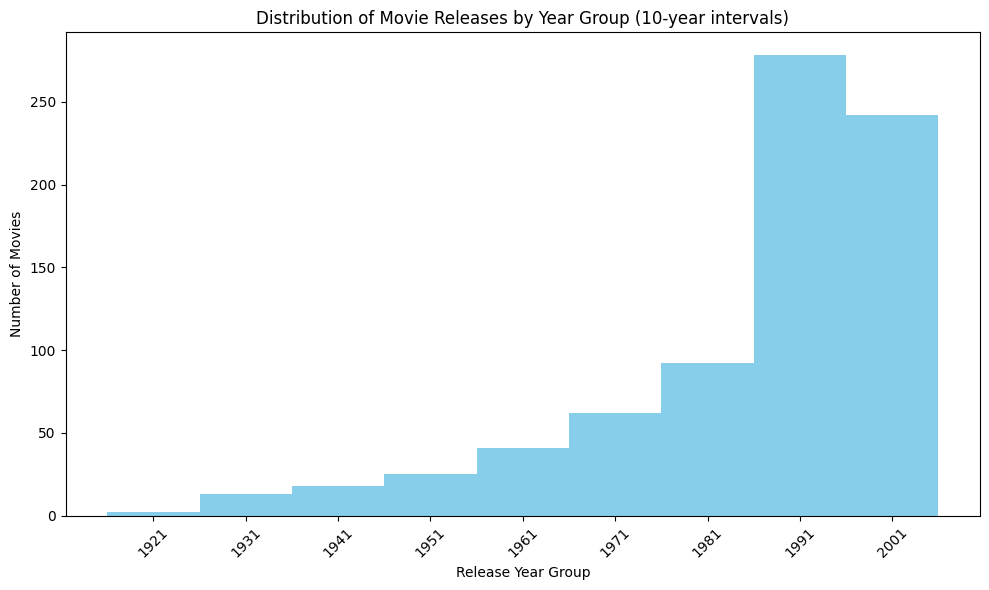

In [56]:
# Define the bin size (10 years)
bin_size = 10

# Extract release years from the 'release_year' column
release_years = (df['year'].astype(int)).tolist()

# Calculate the minimum and maximum release years to determine the range
min_year = min(release_years)
max_year = max(release_years)

# Initialize dictionary to store counts for each bin
bin_counts = {}

# Count the occurrences of each release year within the corresponding bin
for year in release_years:
    bin_index = (year - min_year) // bin_size
    bin_start_year = min_year + bin_index * bin_size
    if bin_start_year in bin_counts:
        bin_counts[bin_start_year] += 1
    else:
        bin_counts[bin_start_year] = 1

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(bin_counts.keys(), bin_counts.values(), color='skyblue', width=bin_size)
plt.xlabel('Release Year Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Releases by Year Group (10-year intervals)')
plt.xticks(range(min_year, max_year + 1, bin_size), rotation=45)
plt.tight_layout()
plt.show(); # to dont export text output

Seems like most movies have been released around the 90s and the 00s in the dataset.

### When were the most ratings placed?

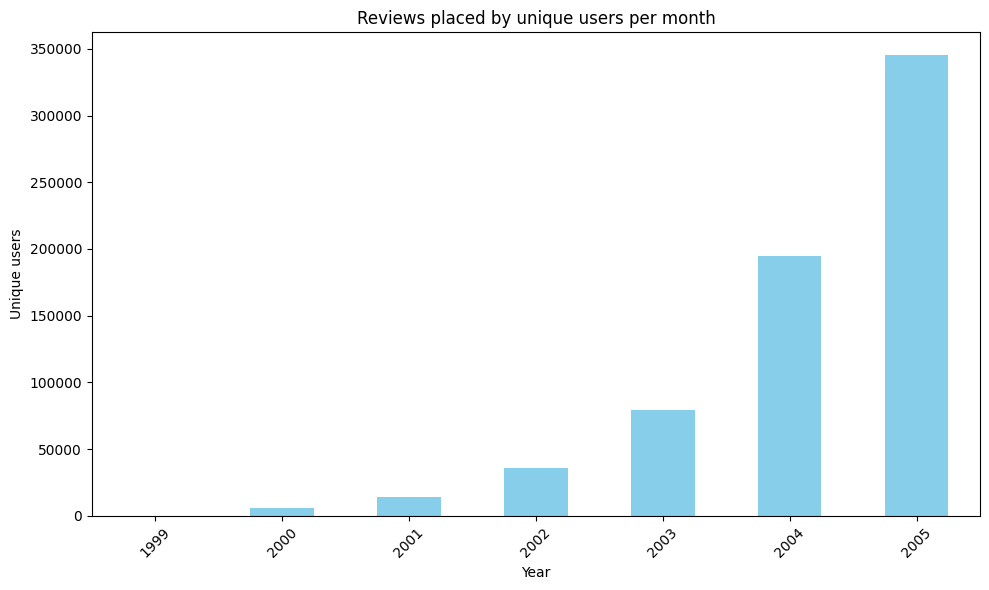

In [57]:
# Extract review dates and user IDs using NumPy
review_data = df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Create a DataFrame with review dates and user IDs
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids})

# Group reviews by month and count the number of unique users for each month
yearly_unique_users = review_df.groupby(review_df['Date'].dt.to_period('Y'))['User_ID'].nunique()

# Plot the number of unique users by month
plt.figure(figsize=(10, 6))
yearly_unique_users.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unique users')
plt.title('Reviews placed by unique users per month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

In 2005, most movies were reviewed by unique users.

### On which days of the week most reviews were placed?

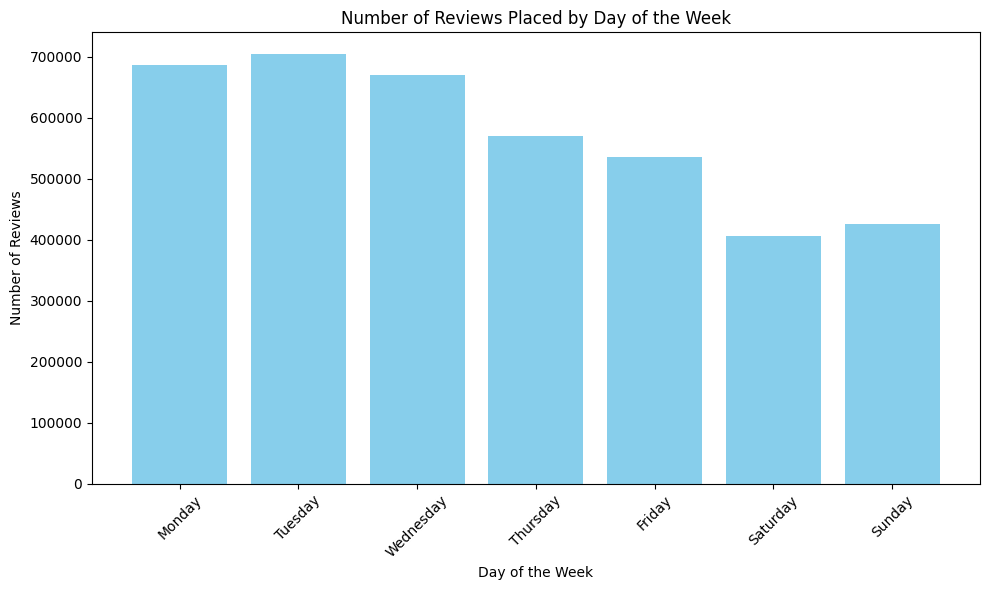

In [58]:
# Get the weekday (0: Monday, 1: Tuesday, ..., 6: Sunday)
weekdays = review_df['Date'].dt.dayofweek

# Count the occurrences of each weekday
weekday_counts = np.bincount(weekdays)

# Plot the distribution of reviews by day of the week
plt.figure(figsize=(10, 6))
plt.bar(range(7), weekday_counts, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Placed by Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.tight_layout()
plt.show();

Most reviews were made on Tuesdays.

### Which movie has the highest average rating?

In [59]:
# Extract review dates, user IDs, and ratings using NumPy
review_data = df['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])
ratings = np.concatenate([np.array([entry['rating'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Extract movie titles
titles = np.concatenate([[title] * len(row) for title, row in zip(df['title'], review_data)])

# Create a DataFrame with review dates, user IDs, ratings, and movie titles
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids, 'Rating': ratings, 'Movie_Title': titles})

In [60]:
review_df.groupby('Movie_Title')['Rating'].mean().sort_values(ascending=False).head(10)
print('{} is the best rated movie on average in this dataset.'.format(review_df.groupby('Movie_Title')['Rating'].mean().idxmax()))

Movie_Title
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material    4.552000
House, M.D.: Season 1                                                          4.522613
Full Metal Panic FUMOFFU                                                       4.451456
Elfen Lied                                                                     4.251880
Scrapped Princess                                                              4.237500
Law & Order: Season 3                                                          4.223117
Chappelle's Show: Season 1                                                     4.211192
Queer as Folk: Season 3                                                        4.196017
Babylon 5: A Call to Arms                                                      4.181247
Aqua Teen Hunger Force: Vol. 1                                                 4.168650
Name: Rating, dtype: float64

Lord of the Rings: The Return of the King: Extended Edition: Bonus Material is the best rated movie on average in this dataset.


In [61]:
# see which movie has received the most amount of reviews
review_df['Movie_Title'].value_counts().head(10)
print('{} has received the highest amount of reviews.'.format(review_df['Movie_Title'].value_counts().idxmax()))

Movie_Title
Pearl Harbor                 173596
Erin Brockovich              130782
Rain Man                     122158
The General's Daughter       118884
Something's Gotta Give       118413
Steel Magnolias              106291
X2: X-Men United              98720
Reservoir Dogs                90450
The Count of Monte Cristo     83564
Taking Lives                  81260
Name: count, dtype: int64

Pearl Harbor has received the highest amount of reviews.


### Handle outliers/distributions:

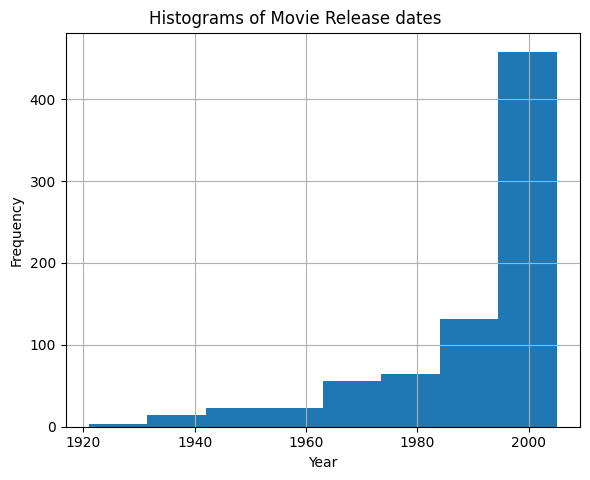

In [62]:
# Plot histogram with bins spanning 10 years
df['year'] = df['year'].astype(int)
plt.figure(figsize=(6, 5))
df['year'].hist(bins=int((df['year'].max() - df['year'].min()) / 10), figsize=(6, 5))
plt.suptitle('Histograms of Movie Release dates', y=0.95)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Data is skewed, as most records are released during the 90s and 00s.

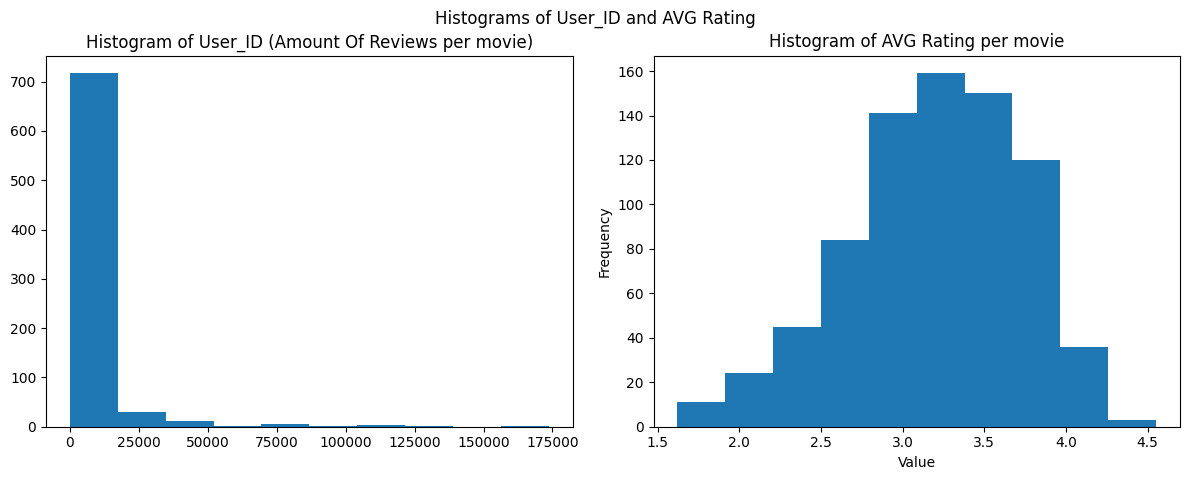

In [63]:
# Group by 'Movie_Title' and calculate count of User_ID and mean of Rating
result_df = review_df.groupby('Movie_Title').agg({'User_ID': 'count', 'Rating': 'mean'}).reset_index()

# Plot histograms for 'User_ID' and 'Rating'
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for 'User_ID'
axs[0].hist(result_df['User_ID'])
axs[0].set_title('Histogram of User_ID (Amount Of Reviews per movie)')

# Histogram for 'Rating'
axs[1].hist(result_df['Rating'])
axs[1].set_title('Histogram of AVG Rating per movie')

# Setting common attributes
plt.suptitle('Histograms of User_ID and AVG Rating', y=0.95)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Amount of reviews is highly skewed, indicating lots of movies with low amounts to now reviews.

AVG Rating is normally distributed, meaning the ratings across movies in the dataset are normally deviating around the mean.

### **Outliers**

Outliers in amount of reviews and release date will not be removed, as they represent users connected to those movies. Those represent a real-world variability which cannot be excluded. 

Furthermore, robust recommender systems should be able to adapt to these outliers and represent valuable information to those users as well. Removing this information would also mean that the model cannot be trained on those.

As the user-item matrix will be sparse, removing outliers would further reduce the size of the data which the model can use to train, which would make it more challenging to build a reliable recommender system.

## Check for Seasonal association with ratings:

# ***insert story and hypotheses for anova, also check for assumptions anova**

In [64]:
# force data into category format and change to month notation to compare months with avg rating
review_df['Date'] = (review_df['Date'].dt.strftime('%B')).astype('category')

In [65]:
# groupby date and aggregate rating by mean
monthly_ratings = review_df.groupby('Date')['Rating'].mean()

C:\Users\SJYHa\AppData\Local\Temp\ipykernel_23172\4273970532.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_ratings = review_df.groupby('Date')['Rating'].mean()


In [71]:
from scipy.stats import f_oneway

# Perform ANOVA
f_statistic, p_value = f_oneway(*[group['Rating'] for name, group in review_df.groupby('Date')])

print("F-Statistic:", f_statistic)
print("P-value:", p_value)

C:\Users\SJYHa\AppData\Local\Temp\ipykernel_23172\1996329645.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f_statistic, p_value = f_oneway(*[group['Rating'] for name, group in review_df.groupby('Date')])


F-Statistic: 71.15074132040002
P-value: 1.0393984497592716e-160


### Handle null values:

In [67]:
df.isnull().sum()
review_df.isnull().sum()
print('There are no null values to handle.')

movieId        0
year           0
title          0
review_data    0
dtype: int64

Date           0
User_ID        0
Rating         0
Movie_Title    0
dtype: int64

There are no null values to handle.
